In [1]:
#imports
import matplotlib.pyplot as plt
import plotly.express as px
from matplotlib import ticker
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split 

2023-01-10 08:53:58.477100: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-10 08:53:58.579249: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/insa/lib:$LD_LIBRARY_PATH
2023-01-10 08:53:58.579266: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-01-10 08:54:00.056231: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot o

## Data Recovery

In [2]:
data = pd.read_csv('data_X_Y.csv', index_col = 0)

In [3]:
data

,Electricity demand,production_nette,production stock,index,Stored phs,Stored battery,Stored methanation,days,cost_phs,cost_bat,cost_met,cost,Stored24phs,Stored24battery,Stored24methanation,stock_day_phs,stock_day_battery,stock_day_methanation
0,822.34,-238.12,244.84,0,100.000000,100.000000,80.483619,1,0.000608,0.003235,0.003928,77.705064,100.000000,0.000000,77.484681,0.000000,-100.000000,-2.998938
1,1011.52,-230.66,253.92,24,100.000000,0.000000,77.484681,2,0.000608,0.003087,0.004208,79.031328,91.461111,0.000000,73.569996,-8.538889,0.000000,-3.914685
2,1429.34,40.22,114.61,48,91.461111,0.000000,73.569996,3,0.000608,0.003182,0.003103,68.930476,88.772222,35.554357,73.343739,-2.688889,35.554357,-0.226256
3,1476.76,-25.91,162.37,72,88.772222,35.554357,73.343739,4,0.000608,0.003113,0.003438,71.594721,81.144444,100.000000,71.943798,-7.627778,64.445643,-1.399942
4,1464.01,-233.79,284.44,96,81.144444,100.000000,71.943798,5,0.000608,0.003112,0.004489,82.088458,100.000000,100.000000,67.112806,18.855556,0.000000,-4.830992
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6564,1395.76,-70.92,124.39,157536,71.872222,71.216617,86.169233,360,0.000608,0.003087,0.003327,70.220758,56.366667,78.041543,85.131638,-15.505556,6.824926,-1.037596
6565,1387.42,13.67,90.03,157560,56.366667,78.041543,85.131638,361,0.000608,0.003087,0.003486,71.809862,100.000000,100.000000,83.575204,43.633333,21.958457,-1.556433
6566,1421.66,-169.79,169.77,157584,100.000000,100.000000,83.575204,362,0.000608,0.003107,0.003430,71.457317,48.972222,86.080388,82.201024,-51.027778,-13.919612,-1.374180
6567,1401.63,-178.55,254.32,157608,48.972222,86.080388,82.201024,363,0.000608,0.003172,0.003719,74.990028,31.444444,42.230914,79.885016,-17.527778,-43.849474,-2.316009


### Ajout de 3 variables label :

- si on stock au max de notre capacité : 2
- si on destock au max de notre capacité : -2
- si on stock (pas au max) : 1
- si on destock (pas au max) : -1
- si on ne fait rien : 0

In [4]:
data['label_phs'] = 0
data['label_battery'] = 0
data['label_methanation'] = 0
for i in data.index:
    #### PHS
    if data.stock_day_phs.loc[i] > 0 :
        data.loc.__setitem__((i, ('label_phs')), 1)
    if data.stock_day_phs.loc[i] < 0 :
        data.loc.__setitem__((i, ('label_phs')), -1)
    if data.Stored24phs.loc[i] == 100 :
        data.loc.__setitem__((i, ('label_phs')), 2)
    if data.Stored24phs.loc[i] == 0 :
        data.loc.__setitem__((i, ('label_phs')), -2)
        
    #### Batterie
    if data.stock_day_battery.loc[i] > 0 :
        data.loc.__setitem__((i, ('label_battery')), 1)
    if data.stock_day_battery.loc[i] < 0 :
        data.loc.__setitem__((i, ('label_battery')), -1)
    if data.Stored24battery.loc[i] == 100:
        data.loc.__setitem__((i, ('label_battery')), 2)
    if data.Stored24battery.loc[i] == 0 :
        data.loc.__setitem__((i, ('label_battery')), -2)
    
    #### Methanation
    if data.stock_day_methanation.loc[i] > 0 :
        data.loc.__setitem__((i, ('label_methanation')), 1)
    if data.stock_day_methanation.loc[i] < 0 :
        data.loc.__setitem__((i, ('label_methanation')), -1)
    if data.Stored24methanation.loc[i] == 100 or data.stock_day_methanation.loc[i] >= 0.86 :
        data.loc.__setitem__((i, ('label_methanation')), 2)
    if data.Stored24methanation.loc[i] == 0 or data.stock_day_methanation.loc[i] <= -14 :
        data.loc.__setitem__((i, ('label_methanation')), -2)

In [5]:
data.columns

Index(['Electricity demand', 'production_nette', 'production stock', 'index',
       'Stored phs', 'Stored battery', 'Stored methanation', 'days',
       'cost_phs', 'cost_bat', 'cost_met', 'cost', 'Stored24phs',
       'Stored24battery', 'Stored24methanation', 'stock_day_phs',
       'stock_day_battery', 'stock_day_methanation', 'label_phs',
       'label_battery', 'label_methanation'],
      dtype='object')

In [6]:
data['label_phs'] = pd.Categorical(data['label_phs'],ordered=False)
data['label_methanation'] = pd.Categorical(data['label_methanation'],ordered=False)
data['label_battery'] = pd.Categorical(data['label_battery'],ordered=False)

to_dum = ['label_phs', 'label_battery', 'label_methanation']
quant_list = ['Electricity demand', 'production_nette', 'production stock', 'index',
       'Stored phs', 'Stored battery', 'Stored methanation', 'days',
       'cost_phs', 'cost_bat', 'cost_met', 'cost', 'Stored24phs',
       'Stored24battery', 'Stored24methanation', 'stock_day_phs',
       'stock_day_battery', 'stock_day_methanation']
# Création de la dataframe train
data_dum = pd.get_dummies(data[to_dum])
print(data_dum)
data_pasdum = data[quant_list]

dfC = pd.concat([data_dum, data_pasdum],axis=1)
dfC

      label_phs_-2  label_phs_-1  label_phs_0  label_phs_1  label_phs_2  \
0                0             0            0            0            1   
1                0             1            0            0            0   
2                0             1            0            0            0   
3                0             1            0            0            0   
4                0             0            0            0            1   
...            ...           ...          ...          ...          ...   
6564             0             1            0            0            0   
6565             0             0            0            0            1   
6566             0             1            0            0            0   
6567             0             1            0            0            0   
6568             0             1            0            0            0   

      label_battery_-2  label_battery_-1  label_battery_0  label_battery_1  \
0                    

,label_phs_-2,label_phs_-1,label_phs_0,label_phs_1,label_phs_2,label_battery_-2,label_battery_-1,label_battery_0,label_battery_1,label_battery_2,...,cost_phs,cost_bat,cost_met,cost,Stored24phs,Stored24battery,Stored24methanation,stock_day_phs,stock_day_battery,stock_day_methanation
0,0,0,0,0,1,1,0,0,0,0,...,0.000608,0.003235,0.003928,77.705064,100.000000,0.000000,77.484681,0.000000,-100.000000,-2.998938
1,0,1,0,0,0,1,0,0,0,0,...,0.000608,0.003087,0.004208,79.031328,91.461111,0.000000,73.569996,-8.538889,0.000000,-3.914685
2,0,1,0,0,0,0,0,0,1,0,...,0.000608,0.003182,0.003103,68.930476,88.772222,35.554357,73.343739,-2.688889,35.554357,-0.226256
3,0,1,0,0,0,0,0,0,0,1,...,0.000608,0.003113,0.003438,71.594721,81.144444,100.000000,71.943798,-7.627778,64.445643,-1.399942
4,0,0,0,0,1,0,0,0,0,1,...,0.000608,0.003112,0.004489,82.088458,100.000000,100.000000,67.112806,18.855556,0.000000,-4.830992
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6564,0,1,0,0,0,0,0,0,1,0,...,0.000608,0.003087,0.003327,70.220758,56.366667,78.041543,85.131638,-15.505556,6.824926,-1.037596
6565,0,0,0,0,1,0,0,0,0,1,...,0.000608,0.003087,0.003486,71.809862,100.000000,100.000000,83.575204,43.633333,21.958457,-1.556433
6566,0,1,0,0,0,0,1,0,0,0,...,0.000608,0.003107,0.003430,71.457317,48.972222,86.080388,82.201024,-51.027778,-13.919612,-1.374180
6567,0,1,0,0,0,0,1,0,0,0,...,0.000608,0.003172,0.003719,74.990028,31.444444,42.230914,79.885016,-17.527778,-43.849474,-2.316009


In [7]:
# Volume max for phs, battery, methanation
volume= pd.Series([180 ,74.14, 12499.09])
Volume= pd.Series([180 ,74.14, 12499.09])

# charging efficiency for phs, batetry, methanation
eta_in = pd.Series([0.95, 0.9, 0.59])
# discharging efficiency for phs, batetry, methanation
eta_out = pd.Series([0.9, 0.95, 0.45])

# Charging capacity phs, battery, methanation (for 1 hour)
S = pd.Series([9.3, 20.08, 7.66])
# discharging capacity phs, battery, methanation (for 1 hour)
Q = pd.Series([9.3, 20.08, 32.93])

# charging/discharging capacity in % for each tech and by day
S_p = [9.3*100*24/volume[0], 20.8*100*24/volume[1], 7.66*100*24/volume[2]]
Q_p = [9.3*100*24/volume[0], 20.08*100*24/volume[1], 32.93*100*24/volume[2]]
print('S % : ', S_p)
print('Q % : ', Q_p)

S % :  [124.00000000000001, 673.3207445373617, 1.4708270762111482]
Q % :  [124.00000000000001, 650.0134879956837, 6.3230203158789955]


## Constraint functions 
- We define 3 main constraints explained more precisely in repport and test it on simulted dataset.

##### 1. Constraint on storage technology level : cannot exceed installed capacity

In [8]:
# Stock level have to be <= 100 % and > 0
def C_level (Stored):
    #############################
    ## Stored is the level of stock for 1 technology in % (depending on Volume_tec)    
    #############################
    print('data where stock level < 0 :', Stored.loc[Stored < 0])
    print('data where stock level > 100 :', Stored.loc[Stored > 100])
    return Stored.loc[Stored < 0], Stored.loc[Stored > 100]

In [9]:
print('for phs : ')
C_level(data['Stored24phs'])
print('for battery : ')
C_level(data['Stored24battery'])
print('for metahanation : ')
C_level(data['Stored24methanation'])

# This constraint is perfectly respected

for phs : 
data where stock level < 0 : Series([], Name: Stored24phs, dtype: float64)
data where stock level > 100 : Series([], Name: Stored24phs, dtype: float64)
for battery : 
data where stock level < 0 : Series([], Name: Stored24battery, dtype: float64)
data where stock level > 100 : Series([], Name: Stored24battery, dtype: float64)
for metahanation : 
data where stock level < 0 : Series([], Name: Stored24methanation, dtype: float64)
data where stock level > 100 : Series([], Name: Stored24methanation, dtype: float64)


(Series([], Name: Stored24methanation, dtype: float64),
 Series([], Name: Stored24methanation, dtype: float64))

##### 2. Contraint on quantity stored or deststock limited by residual production

In [10]:
def C_residualprod(RP,eta_in, eta_out, delta_stock, volume):
    ################################################
    # RP is the residual production : production_nette
    # eta_in Charging efficiency of phs (0), battery (1), methanation (2)
    # eta_out Disharging efficiency of phs (0), battery (1), methanation (2)
    # delta_stock = variation des stocks dans la journée
    # volume = volume max of each tec (useful to unpercent)
    
    # return index of problem
    ################################################   
    
    deltaphs = delta_stock[0]*volume[0]/100
    deltabat = delta_stock[1]*volume[1]/100
    deltamet = delta_stock[2]*volume[2]/100
    #if delta_stock > 0
    deltaphs[deltaphs>0] = deltaphs[deltaphs>0]/eta_in[0]
    deltabat[deltabat>0] = deltabat[deltabat>0]/eta_in[1]
    deltamet[deltamet>0] = deltamet[deltamet>0]/eta_in[2]
    # if delta_stock < 0
    deltaphs[deltaphs<0] = deltaphs[deltaphs<0]*eta_out[0]
    deltabat[deltabat<0] = deltabat[deltabat<0]*eta_out[1]
    deltamet[deltamet<0] = deltamet[deltamet<0]*eta_out[2]

    SUM = deltaphs + deltabat + deltamet
    
    # in all cases : each day, RP have to be lower than sum
    
    print('here there is a problem : ', RP[RP<SUM ], SUM[RP[RP<SUM].index])
    
    return  RP[RP<SUM], SUM[RP[RP<SUM].index], deltaphs, deltabat, deltamet

In [11]:
RP,SUM, simu_phs, simu_bat, simu_met = C_residualprod(data.production_nette,eta_in, eta_out, [data.stock_day_phs, data.stock_day_battery, data.stock_day_methanation], volume)

here there is a problem :  6      -411.95
7      -360.56
8      -327.13
11     -489.08
351    -546.39
         ...  
6213   -327.13
6216   -489.08
6556   -546.39
6562    448.87
6566   -169.79
Name: production_nette, Length: 138, dtype: float64 6      -411.897237
7      -360.558263
8      -327.091500
11     -489.055895
351    -546.372000
           ...    
6213   -327.091500
6216   -489.055895
6556   -546.372000
6562    448.898920
6566   -169.761000
Length: 138, dtype: float64


In [12]:
print ('Maximum difference obseved : ',np.abs((RP-SUM)).max())
# the difference between constraint rejected with most différence is quite hight
# We can consider this value as an acceptable difference

Maximum difference obseved :  0.08800000000019281


##### 3. Constraint on charging and discharging capacity : 
- we cannot charge or dischage more than a fix quantity each day.
- In fact this constraint is only for methanation.

In [13]:
def C_charging_discharging(S_p, Q_p, eta_in, eta_out, delta_stock):
    ###############################################################
    # S_p Charging capacity methanation
    # Q_p Discharging capacity of methanation (2)
    # eta_in Charging efficiency  methanation (2)
    # eta_out Discharging efficiency of  methanation (2)
    # delta_stock : contain daily delta stock for methanation
    
    # return index where there is a problem
    ###############################################################
    # case delta_stock[2] > 0
    delta_met_p = delta_stock[delta_stock>=0]
    print ('too much stockage for methanation : ', delta_met_p[delta_met_p>S_p*eta_in])
    
    
    delta_met_n = delta_stock[delta_stock < 0]
    print ('too much destockage for methanation : ', delta_met_n[delta_met_n < - Q_p/eta_out])
    
    # case delta_stock[2] < 0
    return  delta_met_p[delta_met_p>S_p*eta_in], delta_met_n[delta_met_n < -Q_p/eta_out]

C, D = C_charging_discharging(S_p[2], Q_p[2], eta_in[2], eta_out[2], data.stock_day_methanation)

# error are q_ème surement probably round error 

too much stockage for methanation :  29      0.867823
48      0.867823
60      0.867823
107     0.867823
122     0.867823
          ...   
6550    0.867823
6552    0.867823
6553    0.867823
6561    0.867823
6562    0.867823
Name: stock_day_methanation, Length: 784, dtype: float64
too much destockage for methanation :  Series([], Name: stock_day_methanation, dtype: float64)


In [14]:
print('Theorical maximum methanation : ', S_p[2]*eta_in[2], 'Theorical minimum : ', -Q_p[2]/eta_out[2])
print ('Maximum observed (if upper) : ', C.max(), 'Minimum observed (if lower) : ', D.min())

# We conclude what it is probably round error not important




Theorical maximum methanation :  0.8677879749645774 Theorical minimum :  -14.051156257508879
Maximum observed (if upper) :  0.8678231775273417 Minimum observed (if lower) :  nan


## Données d'entrées (X) / de sorties (Y) du réseau

 - production_nette  $\sum_{str} production - demand$
 - Stored tec = stock level at the beggining of the day

In [15]:
X = data[['production_nette','Stored phs', 'Stored battery', 'Stored methanation', 'days' ]]
X

,production_nette,Stored phs,Stored battery,Stored methanation,days
0,-238.12,100.000000,100.000000,80.483619,1
1,-230.66,100.000000,0.000000,77.484681,2
2,40.22,91.461111,0.000000,73.569996,3
3,-25.91,88.772222,35.554357,73.343739,4
4,-233.79,81.144444,100.000000,71.943798,5
...,...,...,...,...,...
6564,-70.92,71.872222,71.216617,86.169233,360
6565,13.67,56.366667,78.041543,85.131638,361
6566,-169.79,100.000000,100.000000,83.575204,362
6567,-178.55,48.972222,86.080388,82.201024,363


In [16]:

Y = dfC[['label_phs_-2', 'label_phs_-1', 'label_phs_0', 'label_phs_1',
       'label_phs_2', 'label_battery_-2', 'label_battery_-1',
       'label_battery_0', 'label_battery_1', 'label_battery_2',
       'label_methanation_-2', 'label_methanation_-1', 'label_methanation_0',
       'label_methanation_1', 'label_methanation_2','cost']]
Y

,label_phs_-2,label_phs_-1,label_phs_0,label_phs_1,label_phs_2,label_battery_-2,label_battery_-1,label_battery_0,label_battery_1,label_battery_2,label_methanation_-2,label_methanation_-1,label_methanation_0,label_methanation_1,label_methanation_2,cost
0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,77.705064
1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,79.031328
2,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,68.930476
3,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,71.594721
4,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,82.088458
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6564,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,70.220758
6565,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,71.809862
6566,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,71.457317
6567,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,74.990028


### Entrance data normalisation

In [17]:
from sklearn.preprocessing import StandardScaler
scaler = True
if scaler :
    scaler = StandardScaler()
    scaler.fit(X)
    XSc= scaler.transform(X)
    XSc = pd.DataFrame(XSc, index =X.index, columns = X.columns)
else : XSc = X.copy()

## Jeu de test et jeu d'entraînement

In [18]:
X_train,X_test,Y_train,Y_test = train_test_split(XSc,Y,test_size=0.25,random_state=13)

In [19]:
#pour partie stockage
# on ne peut pas mélanger 2 années sinon on a un problème avec predict continu
a = 0
b = 364


# surement mieux de mélanger les trains
X_train_strat = pd.concat([XSc[0:a], XSc[b:]] ) #utilisation des données renormalisées
X_test_strat = XSc[a:b]
Y_train_strat = pd.concat([Y[0:a], Y[b:]])
Y_test_strat = Y[a:b]
X_test_strat

,production_nette,Stored phs,Stored battery,Stored methanation,days
0,-1.476761,2.292299,2.714763,1.102883,-1.727299
1,-1.454558,2.292299,-0.587959,1.011628,-1.717782
2,-0.648339,2.007756,-0.587959,0.892507,-1.708265
3,-0.845162,1.918154,0.586302,0.885622,-1.698749
4,-1.463874,1.663972,2.714763,0.843022,-1.689232
...,...,...,...,...,...
359,-0.979125,1.354993,1.764128,1.275893,1.689232
360,-0.727360,0.838299,1.989536,1.244319,1.698749
361,-1.273391,2.292299,2.714763,1.196958,1.708265
362,-1.299463,0.591893,2.255037,1.155143,1.717782


## Modèles

In [20]:
#some useful methods

def compile_model(model, lr,loss, optimiseur, metrics, loss_weights, run_eagerly):
    model.compile(loss = loss,optimizer=optimiseur,metrics = metrics, loss_weights= loss_weights, run_eagerly = run_eagerly)
def train_model(model,X_train, Y_train, epoch, val):
    model.fit (X_train, Y_train, epochs = epoch, validation_split = val)
def train_model_funk(model, X_trainf, Y_trainf, epoch, val_data):
    model.fit (X_trainf, Y_trainf, epochs = epoch, validation_data = val_data)

In [21]:
def plot_pred ( Y_testr, predr ):
    fig0 = go.Figure()
    fig0.add_traces(go.Scatter( x = Y_testr.index, y = Y_testr['stock_day_phs'], mode='lines', name = 'phs real'))
    fig0.add_traces(go.Scatter(x = predr.index, y = predr['stock_day_phs'], mode='lines', name = 'phs predicted'))
    fig0.show()
    fig1 = go.Figure()
    fig1.add_traces(go.Scatter( x = Y_testr.index, y = Y_testr['stock_day_battery'], mode='lines', name = 'battery real'))
    fig1.add_traces(go.Scatter(x = predr.index, y = predr['stock_day_battery'], mode='lines', name = 'battery predicted'))
    fig1.show()
    fig2 = go.Figure()
    fig2.add_traces(go.Scatter( x = Y_testr.index, y = Y_testr['stock_day_methanation'], mode='lines', name = 'methanation real'))
    fig2.add_traces(go.Scatter(x = predr.index, y = predr['stock_day_methanation'], mode='lines', name = 'methanation predicted'))
    fig2.show()
    fig3 = go.Figure()
    fig3.add_traces(go.Scatter( x = Y_testr.index, y = Y_testr['cost'], mode='lines', name = 'cost real * 10000'))
    fig3.add_traces(go.Scatter(x = predr.index, y = predr['cost'], mode='lines', name = 'cost predicted *10000'))
    fig3.show()
    print('total cost real :', np.sum(Y_testr['cost'])/10000)
    print('total cost predicted :', np.sum(predr['cost'])/10000)

### 1/ Premier modèle construction "classique"

In [22]:
def build_model1(input_size, output_size):
    model = keras.Sequential([
    layers.Dense(128, activation = 'relu', input_shape = input_size),
    layers.Dropout(0.3, seed = 2),
    layers.Dense(128, activation = 'relu'),
    layers.Dense(output_size, activation = 'sigmoid')])
    return model

In [23]:
def build_model1(input_size):
    inputs = keras.Input(shape=(input_size))
    dense1 = layers.Dense(128, activation="relu")
    x = dense1(inputs)
    x = layers.Dropout(0.3, seed = 2)(x)
    x = layers.Dense(128, activation = 'swish')(x)
    x = layers.Dense(128, activation = 'relu')(x)
    x = layers.Dense(128, activation = 'swish')(x)
    x = layers.Dense(128, activation = 'relu')(x)
    branchphs = layers.Dense(5, activation = "softmax")(x)
    branchbat = layers.Dense(5, activation = "softmax")(x)
    branchmet = layers.Dense(5, activation = "softmax")(x)
    branchCost = layers.Dense(1, activation = 'relu')(x)
    outputs =  layers.concatenate([branchphs, branchbat, branchmet, branchCost])
    model = keras.Model(inputs, outputs, name="classification")
    return model

In [24]:
Y_train

,label_phs_-2,label_phs_-1,label_phs_0,label_phs_1,label_phs_2,label_battery_-2,label_battery_-1,label_battery_0,label_battery_1,label_battery_2,label_methanation_-2,label_methanation_-1,label_methanation_0,label_methanation_1,label_methanation_2,cost
995,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,67.043640
641,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,71.568588
3411,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,68.744010
3554,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,68.065500
849,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,67.043640
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
868,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,67.590060
2797,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,68.299860
74,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,67.314750
6337,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,67.675950


In [25]:
input_size = X_train.shape[1]
#output_size = Y_train.shape[1]
lr = 0.005
loss = tf.keras.losses.CategoricalCrossentropy()
optimiseur = tf.keras.optimizers.Adam()
metrics = ['accuracy']
loss_weights = 1
run_eagerly = False
epoch = 10
val = 0.2

model_1 = build_model1(input_size)
model_1.summary()
model = model_1
compile_model(model, lr,loss, optimiseur, metrics,  loss_weights, run_eagerly)
train_model(model,X_train, Y_train, epoch, val)
print("Score jeu test : [loss, accuracy]", model_1.evaluate(X_test,Y_test))

2023-01-10 08:54:07.476185: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/insa/lib:$LD_LIBRARY_PATH
2023-01-10 08:54:07.476984: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-01-10 08:54:07.477019: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (insa-12600): /proc/driver/nvidia/version does not exist


Model: "classification"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 5)]          0           []                               
                                                                                                  
 dense (Dense)                  (None, 128)          768         ['input_1[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 128)          0           ['dense[0][0]']                  
                                                                                                  
 dense_1 (Dense)                (None, 128)          16512       ['dropout[0][0]']                
                                                                                     

2023-01-10 08:54:07.515911: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [26]:
model_1.evaluate(X_test, Y_test)

52/52 [==============================] - 0s 850us/step - loss: 18.3616 - accuracy: 1.0000


[18.361635208129883, 1.0]

##### Predictions

In [27]:
pred_1 = pd.DataFrame(model_1.predict(X_test))
#pred_1.columns = ['stock_day_phs', 'stock_day_battery','stock_day_methanation','cost']
pred_1.index = Y_test.index
pred_1

52/52 [==============================] - 0s 780us/step


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
3724,0.093888,0.799188,1.038278e-14,0.082165,0.024759,0.532882,0.085722,0.001263,0.348660,0.031473,0.052903,0.366509,0.031575,0.533846,0.015167,75.276627
4454,0.659269,0.005288,1.369331e-15,0.333242,0.002202,0.897893,0.000557,0.000003,0.081813,0.019734,0.001565,0.000232,0.001048,0.246169,0.750986,79.579826
3188,0.486118,0.096481,1.245023e-14,0.406862,0.010540,0.723661,0.006856,0.000053,0.234942,0.034487,0.001219,0.009049,0.005371,0.700753,0.283609,74.781761
6115,0.324445,0.186677,2.794938e-13,0.475755,0.013123,0.657452,0.011232,0.000070,0.293863,0.037382,0.000481,0.007054,0.004308,0.720566,0.267591,67.112328
139,0.361684,0.038827,1.854464e-13,0.592732,0.006757,0.803612,0.001831,0.000005,0.163763,0.030789,0.000045,0.000208,0.000580,0.299909,0.699258,67.918167
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4296,0.253501,0.420680,4.965774e-15,0.304453,0.021367,0.521745,0.020206,0.000143,0.413411,0.044495,0.000784,0.052692,0.009721,0.816196,0.120607,76.901283
6104,0.426175,0.124664,1.561172e-13,0.438138,0.011024,0.724584,0.009295,0.000077,0.234237,0.031808,0.001629,0.008161,0.005571,0.725671,0.258969,68.731422
6172,0.626963,0.077117,3.547367e-16,0.285125,0.010795,0.720950,0.006678,0.000077,0.234931,0.037364,0.005602,0.032979,0.011980,0.734235,0.215204,83.435432
1933,0.082374,0.832125,7.481209e-14,0.053975,0.031527,0.557985,0.169227,0.003643,0.234040,0.035105,0.098061,0.546697,0.033987,0.315743,0.005513,70.499680


# Etude d'un stratégie de stockage

## Test des modèles sur des prédictions consécutives (Réalisable ?)

- on coupe X_train et Ytrain à la main de manière à prédire sur une période contigue de l'année : ici l'an 2000. On apprend sur l'autre partie de l'année

#### Prédiction contigue de la stratégie de stockage 

- l'idée est de prédire le stockage en fin de journée j+1 à partir des valeurs prédites en fin de journée j
- ensuite il faut vérifier les contraintes de notre problème.

In [28]:
X_train_strat
X_train_strat = X_train_strat.sample(frac = 1, random_state=13)
Y_train_strat = Y_train_strat.sample(frac = 1, random_state=13)

In [127]:
def pred_conti(model, Y_test, X, a, b):
    
    max_met = 0.8677879749645774
    max_bat = 100
    max_phs = 100
    
    min_met = 14.051156257508879
    min_bat = 100
    min_phs = 100

    pred2 = pd.DataFrame([], columns = ['stock_day_phs', 'stock_day_battery','stock_day_methanation' , 'cost'])
    predl = pd.DataFrame([], columns = ['stock_day_phs', 'stock_day_battery','stock_day_methanation' , 'cost'])
    simu = X[a:b] #input avant sclalerisation !!! meme indice que le X_test_strat
    print(simu)
    for i in range(a,b):
        
        print( '--------------------- jour : ', i, '---------------------')
        sim = pd.DataFrame([simu.iloc[i]], columns = X.columns)
        if scaler:
            simSC = scaler.transform(sim)
        else : simSC = sim
        simds = pd.DataFrame(simSC, columns = X.columns)
        #print(simds)
        pred_brut = model.predict(simds)
        #print(pred_brut)
        #print(tf.argmax(pred_brut[0][:5]))
        
        pred_level = [[None, None, None]]
        pred_level[0][0] = tf.argmax(pred_brut[0][:5]).numpy() -2
        
        pred_level[0][1] = tf.argmax(pred_brut[0][5:10]).numpy() -2
        
        pred_level[0][2] = tf.argmax(pred_brut[0][10:15]).numpy() -2
        
        #print(pred_level)
        
        new_row_level = pd.Series({'stock_day_phs': pred_level[0][0], 'stock_day_battery': pred_level[0][1], 'stock_day_methanation' : pred_level[0][2], 'cost': pred_brut[0][15]})
        predl = pd.concat([predl, new_row_level.to_frame().T], ignore_index=True)
        
        pred = [[None, None, None]]
    
        energie_dispo = simu.at[i, 'production_nette']
        #print(energie_dispo)
        
        
        pred[0][2] = 0
        pred[0][1] = 0
        pred[0][0] = 0
        #print(pred)
        
        #destocke max methanation
        if pred_level[0][2] == -2 :
            print('-2 met max : ', -min_met, -simu.at[i, 'Stored methanation'] )
            pred[0][2] = max(-min_met, -simu.at[i, 'Stored methanation'])
            energie_dispo = energie_dispo - pred[0][2]*Volume[2]/100*eta_out[2]
            print('energy -2 :', energie_dispo)
            print('pred met -2: ', pred [0][2])
        #destock max battery
        if  pred_level[0][1] == -2 :
            print('-2 bat max : ', -min_bat, - simu.at[i, 'Stored battery'])
            pred[0][1] = max(-min_bat, - simu.at[i, 'Stored battery'])
            energie_dispo = energie_dispo - pred[0][1]*Volume[1]/100* eta_out[1]
            print('energy :', energie_dispo)
            print('pred bat -2: ', pred [0][1])
        #destock max methanation
        if  pred_level[0][0] == -2 :
            print('-2 phs max : ', -min_phs, - simu.at[i, 'Stored phs'])
            pred[0][0] = max(-min_phs, - simu.at[i, 'Stored phs'])
            energie_dispo = energie_dispo - pred[0][0]*Volume[0]/100 * eta_out[0]
            print('energy :', energie_dispo)
            print('pred phs -2: ', pred [0][0])
        
        #### CAS stockage
        #### on predit : ce qu'on peut mettre au max par jour dans nos niveau et ce qu'on a de dispo

        #destocke methanation
        if  pred_level[0][2] == -1 :
            print('dans -1 met, max : ', -min_met/2, - simu.at[i, 'Stored methanation'])
            pred[0][2] = max(-min_met/2, - simu.at[i, 'Stored methanation'])
            energie_dispo = energie_dispo - pred[0][2]*Volume[2]/100* eta_out[2]
            print('energy -1 :', energie_dispo)
            print('pred met -1 : ', pred [0][2])
        #destocke battery
        if  pred_level[0][1] == -1 :
            print('dans -1 bat : max ', -min_bat/2., - simu.at[i, 'Stored battery'])
            pred[0][1] = max(-min_bat/2., - simu.at[i, 'Stored battery'])
            energie_dispo = energie_dispo - pred[0][1]*Volume[1]/100* eta_out[1]
            print('energy -1:', energie_dispo)
            print('pred bat -1', pred [0][1])
        #destocke phs
        if  pred_level[0][0] == -1 :
            print('dans -1 phs : max ', -min_phs/2., - simu.at[i, 'Stored phs'])
            pred[0][0] = max(-min_phs/2., - simu.at[i, 'Stored phs'])
            energie_dispo = energie_dispo - pred[0][0]*Volume[0]/100* eta_out[0]
            print('energy -1:', energie_dispo)
            print('pred phs -1', pred [0][0])
        
        if energie_dispo > 0 :
            print('energie positive :', energie_dispo)
            
            #### CAS max stockage
            #### on predit : ce qu'on peut mettre au max par jour dans nos niveau et ce qu'on a de dispo
            
            #stocke max methanation
            if  pred_level[0][2] == 2 :
                print('dans 2 met min : ', max_met, energie_dispo*eta_in[2]*100/Volume[2], (100-simu.at[i, 'Stored methanation']))
                pred[0][2] = min(max_met, energie_dispo*eta_in[2]*100/Volume[2], (100-simu.at[i, 'Stored methanation']))
                energie_dispo = energie_dispo - pred[0][2]*Volume[2]/100/eta_in[2]
                print('energy 2 :', energie_dispo)
                print('pred met 2 ', pred[0][2])
            #stocke max battery
            if  pred_level[0][1] == 2 :
                print('dans 2 bat min : ', max_bat, energie_dispo*eta_in[1]*100/Volume[1], (100-simu.at[i, 'Stored battery']))
                pred[0][1] = min(max_bat, energie_dispo*eta_in[1]*100/Volume[1], (100-simu.at[i, 'Stored battery']))
                energie_dispo = energie_dispo - pred[0][1]*Volume[1]/100/eta_in[1]
                print('energy 2 :', energie_dispo)
                print('pred bat 2 : ', pred[0][1])
            #stocke max phs
            if  pred_level[0][0] == 2 :
                print('dans 2 phs, min : ', max_phs, energie_dispo*eta_in[0]*100/Volume[0],(100-simu.at[i, 'Stored phs']))
                pred[0][0] = min(max_phs, energie_dispo*eta_in[0]*100/Volume[0],(100-simu.at[i, 'Stored phs']))
                energie_dispo = energie_dispo - pred[0][0]*Volume[0]/100/eta_in[0]
                print('energy 2:', energie_dispo)
                print('pred phs 2 : ', pred[0][0])
            
            
            #### CAS stockage
            #### on predit : ce qu'on peut mettre au max par jour dans nos niveau et ce qu'on a de dispo
            
            #stocke battery
            if pred_level[0][1] == 1 :
                print('dans bat 1 , min : ', max_bat/2, energie_dispo*eta_in[1]*100/Volume[1],(100-simu.at[i, 'Stored battery']*Volume[1]/100))
                pred[0][1] = min(max_bat/2, energie_dispo*eta_in[1]*100/Volume[1],(100-simu.at[i, 'Stored battery']))
                energie_dispo = energie_dispo - pred[0][1]*Volume[1]/100/eta_in[1]
                print('energy 1:', energie_dispo)
                print('pred bat :', pred[0][1])
            #stocke phs
            if pred_level[0][0] == 1 :
                print('dans phs 1 : min : ', max_phs/2, energie_dispo*eta_in[0]*100/Volume[0], (100-simu.at[i, 'Stored phs']*Volume[0]/100))
                pred[0][0] = min(max_phs/2, energie_dispo*eta_in[0]*100/Volume[0], (100-simu.at[i, 'Stored phs']))
                energie_dispo = energie_dispo - pred[0][0]*Volume[0]/100/eta_in[0]
                print('energy 1:', energie_dispo)
                print('pred phs 1 :', pred[0][0])
            #stocke methanation
            if  pred_level[0][2] == 1 :
                print( ' dans met 1, min : ', max_met, energie_dispo*eta_in[2]*100/Volume[2],(100-simu.at[i, 'Stored methanation']))
                #print(max_met, energie_dispo*eta_in[2]*100/Volume[2],(100-simu.at[i, 'Stored methanation']*Volume[2]/100))
                pred[0][2] = min(max_met, energie_dispo*eta_in[2]*100/Volume[2],(100-simu.at[i, 'Stored methanation']))
                energie_dispo = energie_dispo - pred[0][2]*Volume[2]/100/eta_in[2]
                print('energy 1 :', energie_dispo)
                print('pred met 1 :', pred[0][2])
        
            
        
        print(pred)
        new_row = pd.Series({'stock_day_phs': pred[0][0], 'stock_day_battery': pred[0][1], 'stock_day_methanation' : pred[0][2], 'cost': pred_brut[0][15]})
        pred2 = pd.concat([pred2, new_row.to_frame().T], ignore_index=True)
        #update of level of stock for to start next day prediction
        #print(simu.at[i,'Stored phs'])
        simu.at[i+1, 'Stored phs'] = simu.at[i,'Stored phs'] + pred[0][0]
        simu.at[i+1, 'Stored battery'] = simu.at[i,'Stored battery'] + pred[0][1]
        simu.at[i+1, 'Stored methanation'] = simu.at[i,'Stored methanation'] + pred[0][2]
    return predl, pred2, simu

### Strat modèle 2 

Il faut faire réaprendre le modèle car les jeux de test/ train sont différents pour la stratégie

In [128]:
'''input_size = [X_train.shape[1]]
output_size = Y_train.shape[1]
lr = 0.05
loss = tf.keras.losses.CategoricalCrossentropy()
optimiseur = tf.keras.optimizers.Adam()
metrics = ['accuracy']
loss_weights = 1
run_eagerly = False
epoch = 10
val = 0.2

model_1 = build_model1 (input_size, output_size)
model_1.summary()
model = model_1
compile_model(model, lr,loss, optimiseur, metrics,  loss_weights, run_eagerly)
train_model(model,X_train, Y_train, epoch, val)
print("Score jeu test : [loss, accuracy]", model_1.evaluate(X_test,Y_test))
'''

input_size = X_train_strat.shape[1]
lr = 0.05
loss = tf.keras.losses.CategoricalCrossentropy()
optimiseur = tf.keras.optimizers.Adam()
metrics = ['accuracy']
loss_weights = 1
run_eagerly = False
epoch = 10
val = 0.2

model_2 = build_model1 (input_size)
model_2.summary()
model = model_2
compile_model(model, lr,loss, optimiseur, metrics, loss_weights, run_eagerly)
train_model(model,X_train_strat, Y_train_strat, epoch, val)
print("Score jeu test : [loss, accuracy]", model_2.evaluate(X_test_strat,Y_test_strat))

Model: "classification"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 5)]          0           []                               
                                                                                                  
 dense_54 (Dense)               (None, 128)          768         ['input_7[0][0]']                
                                                                                                  
 dropout_6 (Dropout)            (None, 128)          0           ['dense_54[0][0]']               
                                                                                                  
 dense_55 (Dense)               (None, 128)          16512       ['dropout_6[0][0]']              
                                                                                     

In [129]:
a = 0
b = 363
prel, pred2, simu = pred_conti(model_2, Y_test_strat,X, a, b)
pred2

     production_nette  Stored phs  Stored battery  Stored methanation  days
0             -238.12       100.0      100.000000           80.483619     1
1             -230.66        50.0       50.000000           73.458041     2
2               40.22        50.0       50.000000           66.432463     3
3              -25.91         0.0        0.000000           67.170897     4
4             -233.79         0.0        0.000000           63.658108     5
..                ...         ...             ...                 ...   ...
358           -374.13       100.0       82.803008            2.762925   359
359            -70.92        25.0        7.803008            0.000000   360
360             13.67       -25.0       -7.803008            0.000000   361
361           -169.79        25.0        7.803008            0.000000   362
362           -178.55       -25.0       -7.803008            0.000000   363

[363 rows x 5 columns]
--------------------- jour :  0 ---------------------
1/1 [=====

1/1 [==============================] - 0s 21ms/step
-2 met max :  -14.051156257508879 -0.0
energy -2 : 59.63999999999987
pred met -2:  -0.0
-2 bat max :  -100 -0.0
energy : 59.63999999999987
pred bat -2:  -0.0
-2 phs max :  -100 -0.0
energy : 59.63999999999987
pred phs -2:  -0.0
energie positive : 59.63999999999987
[[-0.0, -0.0, -0.0]]
--------------------- jour :  19 ---------------------
1/1 [==============================] - 0s 18ms/step
-2 met max :  -14.051156257508879 -0.0
energy -2 : -26.920000000000076
pred met -2:  -0.0
-2 bat max :  -100 -0.0
energy : -26.920000000000076
pred bat -2:  -0.0
-2 phs max :  -100 -0.0
energy : -26.920000000000076
pred phs -2:  -0.0
[[-0.0, -0.0, -0.0]]
--------------------- jour :  20 ---------------------
1/1 [==============================] - 0s 19ms/step
-2 met max :  -14.051156257508879 -0.0
energy -2 : 43.14999999999986
pred met -2:  -0.0
-2 bat max :  -100 -0.0
energy : 43.14999999999986
pred bat -2:  -0.0
-2 phs max :  -100 -0.0
energy : 43

1/1 [==============================] - 0s 16ms/step
-2 bat max :  -100 -0.0
energy : 220.07999999999996
pred bat -2:  -0.0
energie positive : 220.07999999999996
dans phs 1 : min :  50.0 116.15333333333331 100.0
energy 1: 125.34315789473679
pred phs 1 : 50.0
 dans met 1, min :  0.8677879749645774 0.5916627783134188 100.0
energy 1 : -1.4210854715202004e-14
pred met 1 : 0.5916627783134188
[[50.0, -0.0, 0.5916627783134188]]
--------------------- jour :  39 ---------------------
1/1 [==============================] - 0s 17ms/step
dans -1 phs : max  -50.0 -50.0
energy -1: 271.33000000000015
pred phs -1 -50.0
energie positive : 271.33000000000015
dans bat 1 , min :  50.0 329.37280820070157 100.0
energy 1: 230.14111111111126
pred bat : 50.0
 dans met 1, min :  0.8677879749645774 1.0863451303699359 99.40833722168658
energy 1 : 46.301111111111254
pred met 1 : 0.8677879749645774
[[-50.0, 50.0, 0.8677879749645774]]
--------------------- jour :  40 ---------------------
1/1 [=======================

1/1 [==============================] - 0s 19ms/step
-2 bat max :  -100 -0.0
energy : 593.74
pred bat -2:  -0.0
energie positive : 593.74
dans phs 1 : min :  50.0 313.3627777777778 10.0
energy 1: 499.00315789473683
pred phs 1 : 50.0
 dans met 1, min :  0.8677879749645774 2.3554663832158558 99.13221202503543
energy 1 : 315.16315789473686
pred met 1 : 0.8677879749645774
[[50.0, -0.0, 0.8677879749645774]]
--------------------- jour :  59 ---------------------
1/1 [==============================] - 0s 14ms/step
dans -1 phs : max  -50.0 -100.0
energy -1: 619.3899999999999
pred phs -1 -50.0
energie positive : 619.3899999999999
dans bat 1 , min :  50.0 751.8896681953061 100.0
energy 1: 578.201111111111
pred bat : 50.0
 dans met 1, min :  0.8677879749645774 2.7293079380623344 98.26442405007084
energy 1 : 394.361111111111
pred met 1 : 0.8677879749645774
[[-50.0, 50.0, 0.8677879749645774]]
--------------------- jour :  60 ---------------------
1/1 [==============================] - 0s 17ms/step
-

1/1 [==============================] - 0s 20ms/step
-2 bat max :  -100 -0.0
energy : 230.75
pred bat -2:  -0.0
energie positive : 230.75
dans phs 1 : min :  50.0 121.7847222222222 100.0
energy 1: 136.01315789473682
pred phs 1 : 50.0
 dans met 1, min :  0.8677879749645774 0.6420288449630711 97.39663607510627
energy 1 : 0.0
pred met 1 : 0.6420288449630711
[[50.0, -0.0, 0.6420288449630711]]
--------------------- jour :  77 ---------------------
1/1 [==============================] - 0s 19ms/step
dans -1 phs : max  -50.0 -50.0
energy -1: 391.2700000000002
pred phs -1 -50.0
energie positive : 391.2700000000002
dans bat 1 , min :  50.0 474.9703264094958 100.0
energy 1: 350.08111111111134
pred bat : 50.0
 dans met 1, min :  0.8677879749645774 1.6525031466735234 96.7546072301432
energy 1 : 166.24111111111134
pred met 1 : 0.8677879749645774
[[-50.0, 50.0, 0.8677879749645774]]
--------------------- jour :  78 ---------------------
1/1 [==============================] - 0s 19ms/step
-2 bat max : 

1/1 [==============================] - 0s 21ms/step
dans -1 bat : max  -50.0 -50.0
energy -1: 237.41649999999984
pred bat -1 -50.0
dans -1 phs : max  -50.0 -50.0
energy -1: 318.4164999999998
pred phs -1 -50.0
energie positive : 318.4164999999998
 dans met 1, min :  0.8677879749645774 1.5030353009699096 97.39663607510627
energy 1 : 134.5764999999998
pred met 1 : 0.8677879749645774
[[-50.0, -50.0, 0.8677879749645774]]
--------------------- jour :  95 ---------------------
1/1 [==============================] - 0s 16ms/step
-2 bat max :  -100 -0.0
energy : 546.48
pred bat -2:  -0.0
energie positive : 546.48
dans phs 1 : min :  50.0 288.41999999999996 100.0
energy 1: 451.74315789473684
pred phs 1 : 50.0
 dans met 1, min :  0.8677879749645774 2.132382942741389 96.52884810014169
energy 1 : 267.90315789473686
pred met 1 : 0.8677879749645774
[[50.0, -0.0, 0.8677879749645774]]
--------------------- jour :  96 ---------------------
1/1 [==============================] - 0s 16ms/step
-2 bat max :

1/1 [==============================] - 0s 17ms/step
-2 bat max :  -100 -50.0
energy : 359.89650000000006
pred bat -2:  -50.0
energie positive : 359.89650000000006
dans phs 1 : min :  50.0 189.94537500000007 100.0
energy 1: 265.1596578947369
pred phs 1 : 50.0
 dans met 1, min :  0.8677879749645774 1.2516447049976818 81.92361793412243
energy 1 : 81.31965789473688
pred met 1 : 0.8677879749645774
[[50.0, -50.0, 0.8677879749645774]]
--------------------- jour :  113 ---------------------
1/1 [==============================] - 0s 16ms/step
-2 bat max :  -100 -0.0
energy : 79.98000000000002
pred bat -2:  -0.0
dans -1 phs : max  -50.0 -50.0
energy -1: 160.98000000000002
pred phs -1 -50.0
energie positive : 160.98000000000002
 dans met 1, min :  0.8677879749645774 0.7598809193309273 81.05582995915786
energy 1 : 0.0
pred met 1 : 0.7598809193309273
[[-50.0, -0.0, 0.7598809193309273]]
--------------------- jour :  114 ---------------------
1/1 [==============================] - 0s 15ms/step
-2 bat

1/1 [==============================] - 0s 16ms/step
-2 met max :  -14.051156257508879 -0.0
energy -2 : 106.51999999999998
pred met -2:  -0.0
-2 bat max :  -100 -0.0
energy : 106.51999999999998
pred bat -2:  -0.0
-2 phs max :  -100 -0.0
energy : 106.51999999999998
pred phs -2:  -0.0
energie positive : 106.51999999999998
[[-0.0, -0.0, -0.0]]
--------------------- jour :  131 ---------------------
1/1 [==============================] - 0s 15ms/step
-2 bat max :  -100 -0.0
energy : 263.5999999999998
pred bat -2:  -0.0
energie positive : 263.5999999999998
dans phs 1 : min :  50.0 139.1222222222221 100.0
energy 1: 168.86315789473662
pred phs 1 : 50.0
 dans met 1, min :  0.8677879749645774 0.7970921335704807 100.0
energy 1 : 0.0
pred met 1 : 0.7970921335704807
[[50.0, -0.0, 0.7970921335704807]]
--------------------- jour :  132 ---------------------
1/1 [==============================] - 0s 15ms/step
-2 bat max :  -100 -0.0
energy : 93.24000000000012
pred bat -2:  -0.0
dans -1 phs : max  -50.

1/1 [==============================] - 0s 18ms/step
energie positive : 1029.2600000000002
dans bat 1 , min :  50.0 1249.4388993795526 62.93
energy 1: 988.0711111111113
pred bat : 50.0
dans phs 1 : min :  50.0 521.4819753086421 -80.0
energy 1: 988.0711111111113
pred phs 1 : 0.0
 dans met 1, min :  0.8677879749645774 4.664035186206001 88.99935007268529
energy 1 : 804.2311111111113
pred met 1 : 0.8677879749645774
[[0.0, 50.0, 0.8677879749645774]]
--------------------- jour :  149 ---------------------
1/1 [==============================] - 0s 20ms/step
dans -1 bat : max  -50.0 -100.0
energy -1: 537.2265
pred bat -1 -50.0
dans -1 phs : max  -50.0 -100.0
energy -1: 618.2265
pred phs -1 -50.0
energie positive : 618.2265
 dans met 1, min :  0.8677879749645774 2.918241527983237 88.13156209772072
energy 1 : 434.38649999999996
pred met 1 : 0.8677879749645774
[[-50.0, -50.0, 0.8677879749645774]]
--------------------- jour :  150 ---------------------
1/1 [==============================] - 0s 19ms

1/1 [==============================] - 0s 14ms/step
dans -1 phs : max  -50.0 -50.0
energy -1: 393.03
pred phs -1 -50.0
energie positive : 393.03
dans bat 1 , min :  50.0 477.106824925816 100.0
energy 1: 351.8411111111111
pred bat : 50.0
 dans met 1, min :  0.8677879749645774 1.6608109514817122 96.02538532945549
energy 1 : 168.0011111111111
pred met 1 : 0.8677879749645774
[[-50.0, 50.0, 0.8677879749645774]]
--------------------- jour :  167 ---------------------
1/1 [==============================] - 0s 15ms/step
-2 bat max :  -100 -50.0
energy : 382.22649999999976
pred bat -2:  -50.0
energie positive : 382.22649999999976
dans phs 1 : min :  50.0 201.73065277777764 100.0
energy 1: 287.4896578947366
pred phs 1 : 50.0
 dans met 1, min :  0.8677879749645774 1.3570499785015913 95.15759735449092
energy 1 : 103.64965789473658
pred met 1 : 0.8677879749645774
[[50.0, -50.0, 0.8677879749645774]]
--------------------- jour :  168 ---------------------
1/1 [==============================] - 0s 18m

1/1 [==============================] - 0s 15ms/step
-2 met max :  -14.051156257508879 -4.371925966736699
energy -2 : -64.85706740789456
pred met -2:  -4.371925966736699
-2 bat max :  -100 -50.0
energy : -29.640567407894565
pred bat -2:  -50.0
-2 phs max :  -100 -0.0
energy : -29.640567407894565
pred phs -2:  -0.0
[[-0.0, -50.0, -4.371925966736699]]
--------------------- jour :  185 ---------------------
1/1 [==============================] - 0s 16ms/step
-2 bat max :  -100 -0.0
energy : 294.68000000000006
pred bat -2:  -0.0
energie positive : 294.68000000000006
dans phs 1 : min :  50.0 155.52555555555557 100.0
energy 1: 199.94315789473688
pred phs 1 : 50.0
 dans met 1, min :  0.8677879749645774 0.9438004139332924 100.0
energy 1 : 16.10315789473688
pred met 1 : 0.8677879749645774
[[50.0, -0.0, 0.8677879749645774]]
--------------------- jour :  186 ---------------------
1/1 [==============================] - 0s 15ms/step
dans -1 phs : max  -50.0 -50.0
energy -1: 344.8600000000001
pred ph

1/1 [==============================] - 0s 15ms/step
-2 bat max :  -100 -0.0
energy : 400.9599999999998
pred bat -2:  -0.0
energie positive : 400.9599999999998
dans phs 1 : min :  50.0 211.6177777777777 100.0
energy 1: 306.22315789473663
pred phs 1 : 50.0
 dans met 1, min :  0.8677879749645774 1.445478536100585 99.42704468885336
energy 1 : 122.38315789473663
pred met 1 : 0.8677879749645774
[[50.0, -0.0, 0.8677879749645774]]
--------------------- jour :  203 ---------------------
1/1 [==============================] - 0s 14ms/step
-2 bat max :  -100 -0.0
energy : 952.85
pred bat -2:  -0.0
energie positive : 952.85
dans phs 1 : min :  50.0 502.8930555555556 10.0
energy 1: 858.1131578947369
pred phs 1 : 50.0
 dans met 1, min :  0.8677879749645774 4.050588988141494 98.55925671388877
energy 1 : 674.2731578947369
pred met 1 : 0.8677879749645774
[[50.0, -0.0, 0.8677879749645774]]
--------------------- jour :  204 ---------------------
1/1 [==============================] - 0s 16ms/step
dans -1

1/1 [==============================] - 0s 19ms/step
-2 met max :  -14.051156257508879 -9.268456848921758
energy -2 : 354.35274342105254
pred met -2:  -9.268456848921758
-2 bat max :  -100 -0.0
energy : 354.35274342105254
pred bat -2:  -0.0
-2 phs max :  -100 -0.0
energy : 354.35274342105254
pred phs -2:  -0.0
energie positive : 354.35274342105254
[[-0.0, -0.0, -9.268456848921758]]
--------------------- jour :  221 ---------------------
1/1 [==============================] - 0s 16ms/step
-2 met max :  -14.051156257508879 -0.0
energy -2 : 55.75
pred met -2:  -0.0
-2 bat max :  -100 -0.0
energy : 55.75
pred bat -2:  -0.0
-2 phs max :  -100 -0.0
energy : 55.75
pred phs -2:  -0.0
energie positive : 55.75
[[-0.0, -0.0, -0.0]]
--------------------- jour :  222 ---------------------
1/1 [==============================] - 0s 19ms/step
-2 bat max :  -100 -0.0
energy : 242.0799999999997
pred bat -2:  -0.0
energie positive : 242.0799999999997
dans phs 1 : min :  50.0 127.7644444444443 100.0
energy

1/1 [==============================] - 0s 16ms/step
-2 bat max :  -100 -0.0
energy : 198.7800000000002
pred bat -2:  -0.0
-2 phs max :  -100 -0.0
energy : 198.7800000000002
pred phs -2:  -0.0
energie positive : 198.7800000000002
 dans met 1, min :  0.8677879749645774 0.9383099089613733 96.52884810014169
energy 1 : 14.940000000000197
pred met 1 : 0.8677879749645774
[[-0.0, -0.0, 0.8677879749645774]]
--------------------- jour :  239 ---------------------
1/1 [==============================] - 0s 16ms/step
-2 bat max :  -100 -0.0
energy : 617.7699999999999
pred bat -2:  -0.0
energie positive : 617.7699999999999
dans phs 1 : min :  50.0 326.0452777777777 100.0
energy 1: 523.0331578947367
pred phs 1 : 50.0
 dans met 1, min :  0.8677879749645774 2.4688962409094954 95.66106012517712
energy 1 : 339.1931578947367
pred met 1 : 0.8677879749645774
[[50.0, -0.0, 0.8677879749645774]]
--------------------- jour :  240 ---------------------
1/1 [==============================] - 0s 17ms/step
-2 bat m

1/1 [==============================] - 0s 15ms/step
-2 met max :  -14.051156257508879 -0.0
energy -2 : -14.220000000000027
pred met -2:  -0.0
-2 bat max :  -100 -0.0
energy : -14.220000000000027
pred bat -2:  -0.0
-2 phs max :  -100 -0.0
energy : -14.220000000000027
pred phs -2:  -0.0
[[-0.0, -0.0, -0.0]]
--------------------- jour :  258 ---------------------
1/1 [==============================] - 0s 19ms/step
-2 bat max :  -100 -0.0
energy : 424.3299999999999
pred bat -2:  -0.0
energie positive : 424.3299999999999
dans phs 1 : min :  50.0 223.9519444444444 100.0
energy 1: 329.59315789473675
pred phs 1 : 50.0
 dans met 1, min :  0.8677879749645774 1.5557929669911543 100.0
energy 1 : 145.75315789473674
pred met 1 : 0.8677879749645774
[[50.0, -0.0, 0.8677879749645774]]
--------------------- jour :  259 ---------------------
1/1 [==============================] - 0s 15ms/step
-2 bat max :  -100 -0.0
energy : 837.0399999999996
pred bat -2:  -0.0
energie positive : 837.0399999999996
dans p

1/1 [==============================] - 0s 17ms/step
-2 bat max :  -100 -0.0
energy : 426.94000000000005
pred bat -2:  -0.0
dans -1 phs : max  -50.0 -50.0
energy -1: 507.94000000000005
pred phs -1 -50.0
energie positive : 507.94000000000005
 dans met 1, min :  0.8677879749645774 2.3976513490182083 98.28764814078465
energy 1 : 324.1
pred met 1 : 0.8677879749645774
[[-50.0, -0.0, 0.8677879749645774]]
--------------------- jour :  276 ---------------------
1/1 [==============================] - 0s 18ms/step
-2 met max :  -14.051156257508879 -2.5801398341799278
energy -2 : 128.92229999999992
pred met -2:  -2.5801398341799278
-2 bat max :  -100 -0.0
energy : 128.92229999999992
pred bat -2:  -0.0
-2 phs max :  -100 -0.0
energy : 128.92229999999992
pred phs -2:  -0.0
energie positive : 128.92229999999992
[[-0.0, -0.0, -2.5801398341799278]]
--------------------- jour :  277 ---------------------
1/1 [==============================] - 0s 18ms/step
-2 met max :  -14.051156257508879 -0.0
energy -2

1/1 [==============================] - 0s 16ms/step
-2 bat max :  -100 -0.0
energy : 395.7399999999999
pred bat -2:  -0.0
dans -1 phs : max  -50.0 -50.0
energy -1: 476.7399999999999
pred phs -1 -50.0
energie positive : 476.7399999999999
 dans met 1, min :  0.8677879749645774 2.2503766274184756 99.13221202503543
energy 1 : 292.89999999999986
pred met 1 : 0.8677879749645774
[[-50.0, -0.0, 0.8677879749645774]]
--------------------- jour :  296 ---------------------
1/1 [==============================] - 0s 16ms/step
-2 met max :  -14.051156257508879 -1.7355759499291548
energy -2 : 173.14904000000018
pred met -2:  -1.7355759499291548
-2 bat max :  -100 -0.0
energy : 173.14904000000018
pred bat -2:  -0.0
-2 phs max :  -100 -0.0
energy : 173.14904000000018
pred phs -2:  -0.0
energie positive : 173.14904000000018
[[-0.0, -0.0, -1.7355759499291548]]
--------------------- jour :  297 ---------------------
1/1 [==============================] - 0s 16ms/step
-2 met max :  -14.051156257508879 -0.0

1/1 [==============================] - 0s 17ms/step
-2 met max :  -14.051156257508879 -2.8736814840120366
energy -2 : 153.3228157500003
pred met -2:  -2.8736814840120366
-2 bat max :  -100 -0.0
energy : 153.3228157500003
pred bat -2:  -0.0
-2 phs max :  -100 -0.0
energy : 153.3228157500003
pred phs -2:  -0.0
energie positive : 153.3228157500003
[[-0.0, -0.0, -2.8736814840120366]]
--------------------- jour :  314 ---------------------
1/1 [==============================] - 0s 18ms/step
-2 bat max :  -100 -0.0
energy : 233.17999999999984
pred bat -2:  -0.0
-2 phs max :  -100 -0.0
energy : 233.17999999999984
pred phs -2:  -0.0
energie positive : 233.17999999999984
 dans met 1, min :  0.8677879749645774 1.1006897302123584 100.0
energy 1 : 49.33999999999983
pred met 1 : 0.8677879749645774
[[-0.0, -0.0, 0.8677879749645774]]
--------------------- jour :  315 ---------------------
1/1 [==============================] - 0s 17ms/step
-2 bat max :  -100 -0.0
energy : 797.8499999999999
pred bat -

1/1 [==============================] - 0s 16ms/step
-2 bat max :  -100 -50.0
energy : 277.9865
pred bat -2:  -50.0
dans -1 phs : max  -50.0 -50.0
energy -1: 358.9865
pred phs -1 -50.0
energie positive : 358.9865
 dans met 1, min :  0.8677879749645774 1.6945396424859729 100.0
energy 1 : 175.14649999999997
pred met 1 : 0.8677879749645774
[[-50.0, -50.0, 0.8677879749645774]]
--------------------- jour :  333 ---------------------
1/1 [==============================] - 0s 18ms/step
-2 bat max :  -100 -0.0
energy : 241.80999999999997
pred bat -2:  -0.0
-2 phs max :  -100 -0.0
energy : 241.80999999999997
pred phs -2:  -0.0
energie positive : 241.80999999999997
 dans met 1, min :  0.8677879749645774 1.1414262958343364 99.13221202503543
energy 1 : 57.96999999999997
pred met 1 : 0.8677879749645774
[[-0.0, -0.0, 0.8677879749645774]]
--------------------- jour :  334 ---------------------
1/1 [==============================] - 0s 18ms/step
-2 bat max :  -100 -0.0
energy : 102.0200000000002
pred b

1/1 [==============================] - 0s 17ms/step
-2 bat max :  -100 -0.0
energy : 200.39999999999984
pred bat -2:  -0.0
-2 phs max :  -100 -0.0
energy : 200.39999999999984
pred phs -2:  -0.0
energie positive : 200.39999999999984
 dans met 1, min :  0.8677879749645774 0.9459568656598192 84.98992248109346
energy 1 : 16.55999999999983
pred met 1 : 0.8677879749645774
[[-0.0, -0.0, 0.8677879749645774]]
--------------------- jour :  351 ---------------------
1/1 [==============================] - 0s 17ms/step
-2 bat max :  -100 -0.0
energy : -546.39
pred bat -2:  -0.0
-2 phs max :  -100 -0.0
energy : -546.39
pred phs -2:  -0.0
dans -1 met, max :  -7.025578128754439 -15.877865493871116
energy -1 : -151.22999999999996
pred met -1 :  -7.025578128754439
[[-0.0, -0.0, -7.025578128754439]]
--------------------- jour :  352 ---------------------
1/1 [==============================] - 0s 16ms/step
-2 met max :  -14.051156257508879 -8.852287365116677
energy -2 : 334.834914171053
pred met -2:  -8.8

/tmp/ipykernel_4410/581869185.py:160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  simu.at[i+1, 'Stored phs'] = simu.at[i,'Stored phs'] + pred[0][0]


,stock_day_phs,stock_day_battery,stock_day_methanation,cost
0,-50.0,-50.0,-7.025578,90.861938
1,-50.0,-50.0,-7.025578,75.521622
2,-0.0,-0.0,0.189852,78.655022
3,-0.0,-0.0,0.000000,81.382080
4,-0.0,-0.0,-7.025578,91.713554
...,...,...,...,...
358,-0.0,-0.0,-3.364142,105.402466
359,-0.0,-0.0,-0.000000,88.433372
360,-0.0,-0.0,-0.000000,84.732895
361,-0.0,-0.0,-0.000000,93.500229


In [130]:
pred2

,stock_day_phs,stock_day_battery,stock_day_methanation,cost
0,-50.0,-50.0,-7.025578,90.861938
1,-50.0,-50.0,-7.025578,75.521622
2,-0.0,-0.0,0.189852,78.655022
3,-0.0,-0.0,0.000000,81.382080
4,-0.0,-0.0,-7.025578,91.713554
...,...,...,...,...
358,-0.0,-0.0,-3.364142,105.402466
359,-0.0,-0.0,-0.000000,88.433372
360,-0.0,-0.0,-0.000000,84.732895
361,-0.0,-0.0,-0.000000,93.500229


In [131]:
prel

,stock_day_phs,stock_day_battery,stock_day_methanation,cost
0,-1.0,-1.0,-1.0,90.861938
1,-1.0,-1.0,-1.0,75.521622
2,-1.0,-2.0,1.0,78.655022
3,-1.0,-2.0,1.0,81.382080
4,-1.0,-2.0,-1.0,91.713554
...,...,...,...,...
358,-2.0,-2.0,-2.0,105.402466
359,-2.0,-2.0,-2.0,88.433372
360,-2.0,-2.0,-2.0,84.732895
361,-2.0,-2.0,-2.0,93.500229


In [132]:
simu

,production_nette,Stored phs,Stored battery,Stored methanation,days
0,-238.12,100.0,100.0,80.483619,1.0
1,-230.66,50.0,50.0,73.458041,2.0
2,40.22,0.0,0.0,66.432463,3.0
3,-25.91,0.0,0.0,66.622315,4.0
4,-233.79,0.0,0.0,66.622315,5.0
...,...,...,...,...,...
359,-70.92,0.0,0.0,0.000000,360.0
360,13.67,0.0,0.0,0.000000,361.0
361,-169.79,0.0,0.0,0.000000,362.0
362,-178.55,0.0,0.0,0.000000,363.0


In [133]:
print('methanation : ')
C_charging_discharging(S_p[2], Q_p[2], eta_in[2], eta_out[2], pred2.stock_day_methanation)

methanation : 
too much stockage for methanation :  Series([], Name: stock_day_methanation, dtype: float64)
too much destockage for methanation :  Series([], Name: stock_day_methanation, dtype: float64)


(Series([], Name: stock_day_methanation, dtype: float64),
 Series([], Name: stock_day_methanation, dtype: float64))

In [134]:
if scaler : 
    X_pred2 = scaler.inverse_transform(X_test_strat)
else : X_pred2 = X_test_strat
X_pred2 = pd.DataFrame(X_pred2, columns = ['production_nette', 'Stored phs', 'Stored battery',
       'Stored methanation', 'days'])
X_pred2

,production_nette,Stored phs,Stored battery,Stored methanation,days
0,-238.12,100.000000,100.000000,80.483619,1.0
1,-230.66,100.000000,0.000000,77.484681,2.0
2,40.22,91.461111,0.000000,73.569996,3.0
3,-25.91,88.772222,35.554357,73.343739,4.0
4,-233.79,81.144444,100.000000,71.943798,5.0
...,...,...,...,...,...
359,-70.92,71.872222,71.216617,86.169233,360.0
360,13.67,56.366667,78.041543,85.131638,361.0
361,-169.79,100.000000,100.000000,83.575204,362.0
362,-178.55,48.972222,86.080388,82.201024,363.0


In [135]:
pred2['stock_day_methanation'] = pred2['stock_day_methanation']
pred2

,stock_day_phs,stock_day_battery,stock_day_methanation,cost
0,-50.0,-50.0,-7.025578,90.861938
1,-50.0,-50.0,-7.025578,75.521622
2,-0.0,-0.0,0.189852,78.655022
3,-0.0,-0.0,0.000000,81.382080
4,-0.0,-0.0,-7.025578,91.713554
...,...,...,...,...
358,-0.0,-0.0,-3.364142,105.402466
359,-0.0,-0.0,-0.000000,88.433372
360,-0.0,-0.0,-0.000000,84.732895
361,-0.0,-0.0,-0.000000,93.500229


In [136]:
RP,SUM, phsc, batc, metc = C_residualprod(X_pred2.production_nette[:-1],eta_in, eta_out, [pred2.stock_day_phs, pred2.stock_day_battery, pred2.stock_day_methanation], volume)

here there is a problem :  3      -25.91
6     -411.95
10    -595.96
11    -489.08
12    -442.69
13    -260.95
16     -67.01
19     -26.92
23    -289.57
26      -2.86
31     -45.50
33     -21.88
38     220.08
41     -34.04
43    -157.48
50    -276.28
56     -38.08
72     -32.53
86     163.35
90    -197.44
100    247.40
184   -310.76
187     41.31
200     -2.51
201    121.38
243    -66.15
247     34.86
252    116.97
256    -58.12
257    -14.22
263    -94.85
277   -324.44
278    -90.27
279    -64.74
286   -455.23
287   -160.94
288   -107.20
290    -65.41
292   -268.92
297    -41.03
299   -126.85
318    -33.41
319     -2.54
328     -7.16
337    213.79
351   -546.39
353   -102.05
358   -374.13
359    -70.92
361   -169.79
362   -178.55
Name: production_nette, dtype: float64 3        0.000000
6     -395.160000
10    -190.792410
11      -0.000000
12      -0.000000
13      -0.000000
16      -0.000000
19      -0.000000
23    -213.835540
26      -0.000000
31      -0.000000
33      -0.000000
38  

In [137]:
len(RP[RP<0])

43

In [138]:
SUM[RP>0]

38     220.08
86     163.35
100    247.40
187     41.31
201    121.38
247     34.86
252    116.97
337    213.79
dtype: float64

In [144]:
RP[RP>0]

38     220.08
86     163.35
100    247.40
187     41.31
201    121.38
247     34.86
252    116.97
337    213.79
Name: production_nette, dtype: float64

In [139]:
print ('Maximum difference obseved : ',np.abs((RP-SUM)).max())

Maximum difference obseved :  489.0800000000001


In [140]:
print('for phs : ')
C_level(simu['Stored phs'])
print('for battery : ')
C_level(simu['Stored battery'])
print('for metahanation : ')
C_level(simu['Stored methanation'])

for phs : 
data where stock level < 0 : Series([], Name: Stored phs, dtype: float64)
data where stock level > 100 : Series([], Name: Stored phs, dtype: float64)
for battery : 
data where stock level < 0 : Series([], Name: Stored battery, dtype: float64)
data where stock level > 100 : Series([], Name: Stored battery, dtype: float64)
for metahanation : 
data where stock level < 0 : Series([], Name: Stored methanation, dtype: float64)
data where stock level > 100 : Series([], Name: Stored methanation, dtype: float64)


(Series([], Name: Stored methanation, dtype: float64),
 Series([], Name: Stored methanation, dtype: float64))

In [141]:
def show_simu(start,finish,d):
    col = {"production_nette" : "#00FFFF", "phs" : "#DDC79E", "battery" : "#EC9AC8", "methanation": "#9AECC2"}
    tec = []
    stor = ["phs","battery","methanation"]

    Volume = pd.Series([180 ,74.14, 12499.09])

    x = "phs"

    tec_aux = tec
    if not("river" in d.columns): tec_aux = list(set(tec_aux) - set(["river"]))
    if not("lake" in d.columns): tec_aux = list(set(tec_aux) - set(["lake"]))
    
    h  = np.arange(start,finish)
    ymin, ymax = -760,1445
    #ymin, ymax= 0,50
    fig2, axs2 = plt.subplots(1, figsize = (15,5))
    
    # Stockage 
    sum_s = 0
    for i in stor: 
        print(i)
        sum_s += d["storage_" + i][h]
    for s in stor[::-1]:
        aux = "storage_" + s
        axs2.fill_between(h, sum_s, color = col[s], label = aux)
        sum_s -= d[aux][h]

    # Production
    sum_g = 0
    for i in tec_aux: 
        sum_g += d[i][h]
    for gene in tec_aux[::-1]: 
        axs2.fill_between(h,sum_g, color = col[gene], label = gene )
        sum_g -= d[gene][h]
    
    # Demande
    axs2.plot(h, d["production_nette"][h], color = 'black' , label = "residual production",linewidth= 2)

    axs2.vlines(x=np.linspace(h[0],h[-1],8),ymin = ymin, ymax = ymax,colors="black",linestyle='dotted',linewidth=2)
    axs2.set_ylabel("Energy volume (GWh)")
    axs2.set_ylim(ymin,ymax)
    axs2.legend(loc ="upper right")
    axs2.set_title("Hours "+ str(start)+" to "+str(finish))

In [142]:
X_pred2.min()

production_nette     -735.18
Stored phs              0.00
Stored battery          0.00
Stored methanation      0.00
days                    1.00
dtype: float64

In [143]:
df = pred2.merge(X_pred2[:-1],right_index = True, left_index = True)
df['storage_phs']=phsc
df['storage_battery']=batc
df['storage_methanation']=metc
#df


phs
battery
methanation


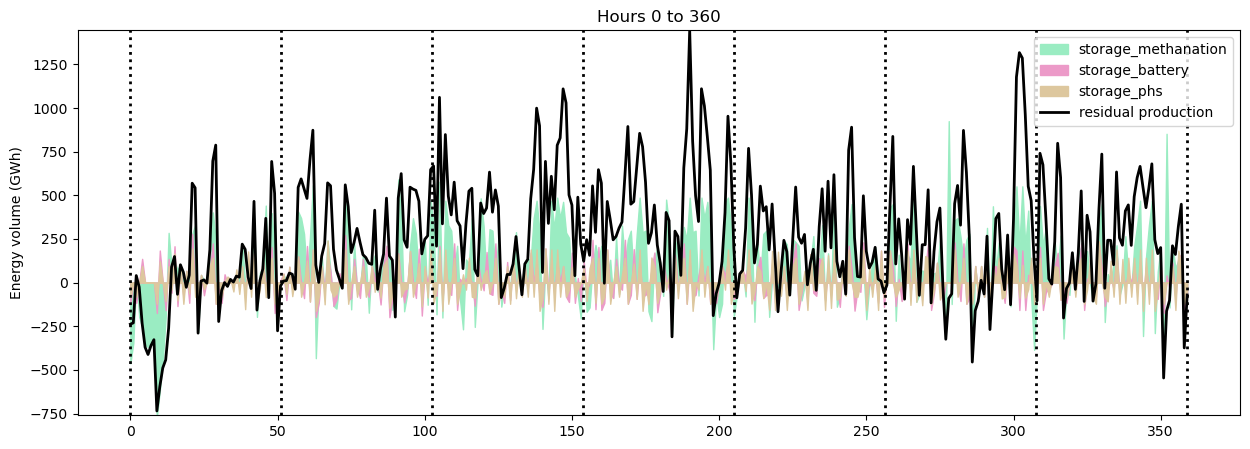

In [111]:
show_simu(0,360,df)

phs
battery
methanation


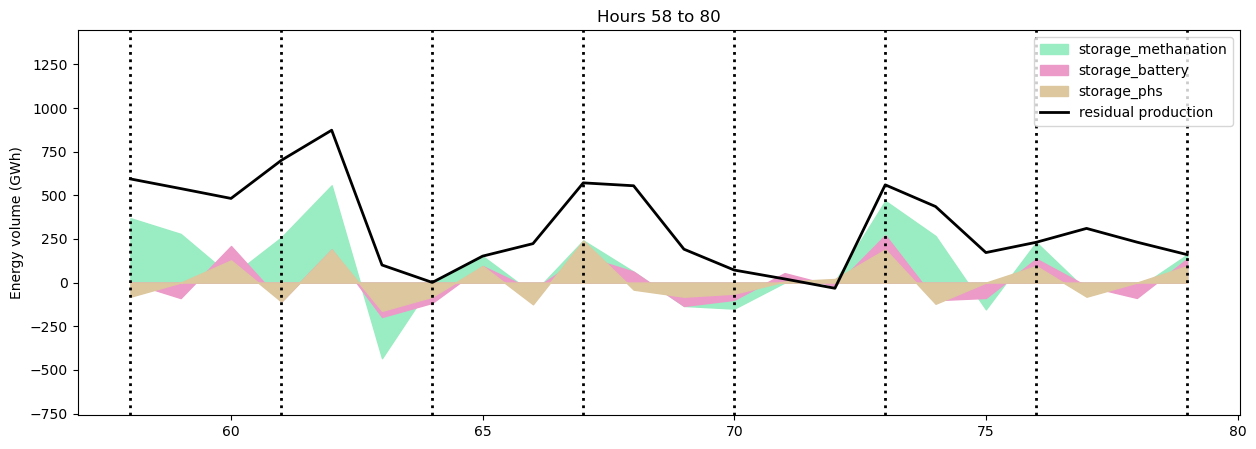

In [112]:
show_simu(58,80,df)

In [49]:
df_simu = data.copy()
df_simu['storage_phs']=simu_phs
df_simu['storage_battery']=simu_bat
df_simu['storage_methanation']=simu_met

phs
battery
methanation


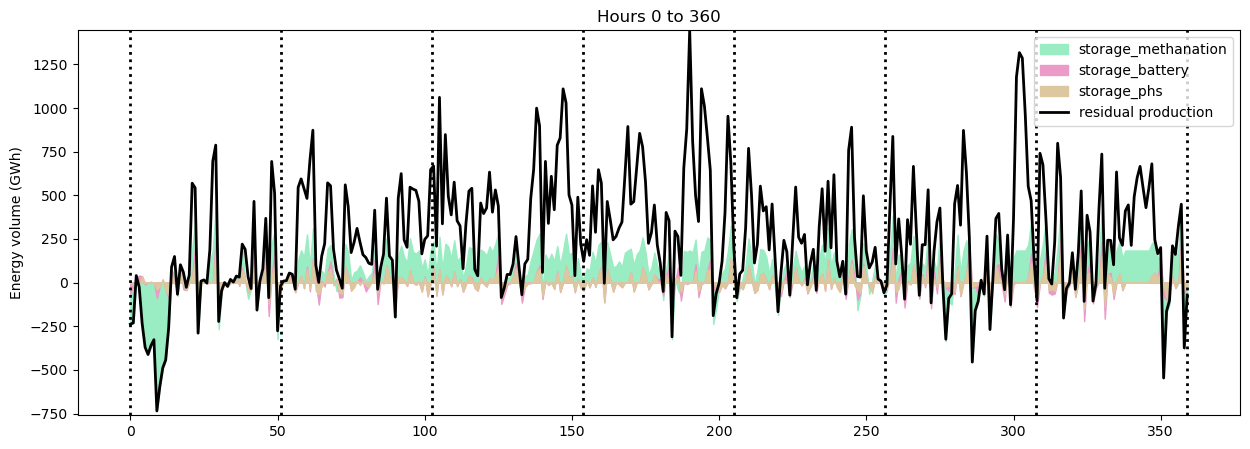

In [50]:
show_simu(0,360,df_simu)

phs
battery
methanation


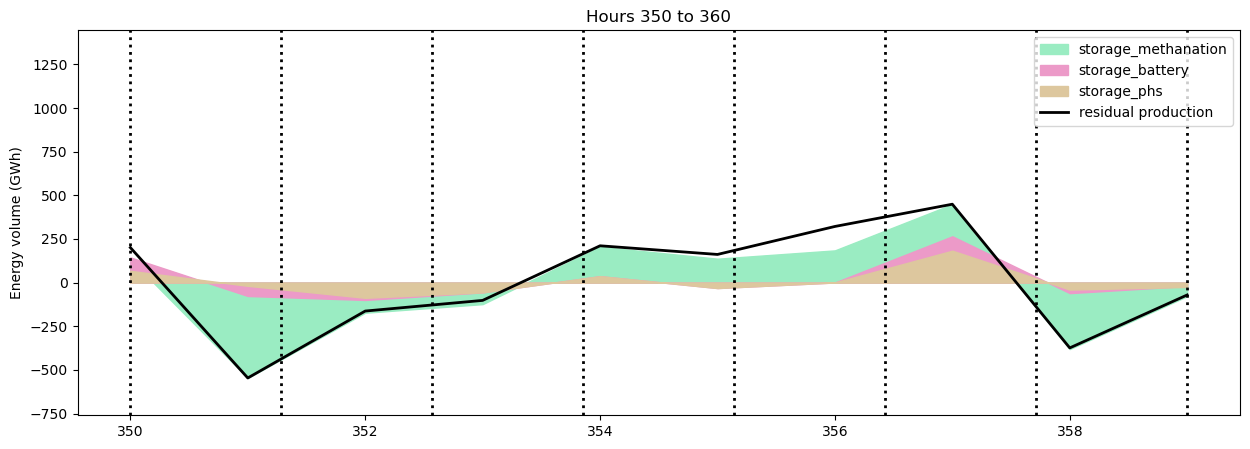

In [51]:
show_simu(350,360,df_simu)